In [26]:
import random
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from rdkit import Chem
import msml.utils.data as du
import msml.utils.spectra as su
import msml.utils.mols as mu
import msml.utils.io as io
import msml.utils.plots as plots
from msml.definitions import *

In [23]:
atlas_dir = Path('/storage/plzen1/home/romanb/DreaMS_Atlas')
gems_dir = Path('/storage/plzen1/home/romanb/msvn_C/')

In [3]:
lib = du.MSData('/auto/brno2/home/romanb/msml/msml/data/merged/datasets/nist20_mona_clean_merged_spectra_dreams.hdf5')
gems = du.MSData(gems_dir / 'msvn_C_H1000_KK1.merged.hdf5')
print(lib.num_spectra, gems.num_spectra, lib.num_spectra + gems.num_spectra)
def get_item(i, val=PRECURSOR_MZ):
    if i <= lib.num_spectra:
        return lib.get_values(val, i)
    else:
        res = gems.get_values(val, i - lib.num_spectra)
        if val == SPECTRUM:
            res = res.T
        return res

knn = du.CSRKNN.from_npz(atlas_dir / 'DreaMS_Atlas_3NN_merged40079300_09_pruned.npz')
print(knn.n_nodes, knn.n_edges, knn.k)

df_clusters = pd.read_csv(atlas_dir / 'DreaMS_Atlas_3NN_merged40079300_09_pruned_clusters.csv')

79300 75520646 75599946
33631113 134524452 3


In [4]:
cluster_idx_1 = np.array(io.read_pickle(atlas_dir / 'DreaMS_Atlas_3NN_merged40079300_09_cluster_idx.pkl'))
cluster_idx_2 = np.array(io.read_pickle(atlas_dir / 'DreaMS_Atlas_3NN_merged40079300_09_pruned_cluster_idx.pkl'))
def encode_knn_i(i):
    e1 = np.where(np.array(cluster_idx_1) == i)[0].item()
    e2 = np.where(np.array(cluster_idx_2) == e1)[0].item()
    return e2
def decode_knn_i(i):
    return cluster_idx_1[cluster_idx_2[i]]

In [12]:
g = knn.to_igraph()

Constructing graph edges: 100%|██████████| 33631113/33631113 [03:30<00:00, 159600.06it/s]


In [7]:
pl_mod_cos = su.PeakListModifiedCosine()
def mod_cos(i, j):
    return pl_mod_cos(
        spec1=su.unpad_peak_list(get_item(i, SPECTRUM)),
        spec2=su.unpad_peak_list(get_item(j, SPECTRUM)),
        prec_mz1=get_item(i, PRECURSOR_MZ).item(),
        prec_mz2=get_item(j, PRECURSOR_MZ).item()
    )

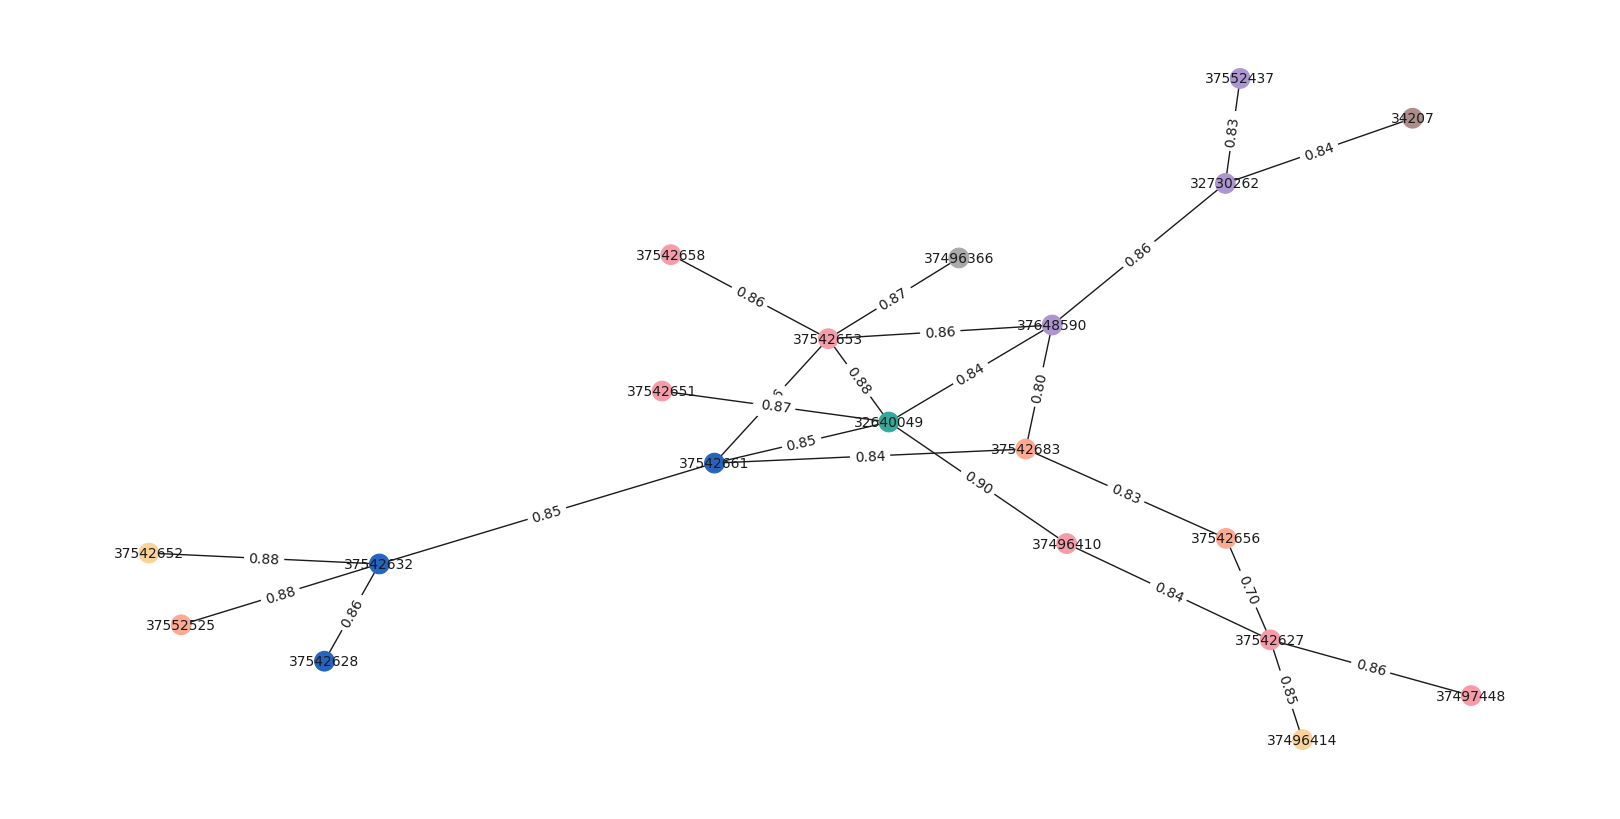

In [68]:
import matplotlib as mpl
import networkx as nx
import numpy as np
from collections import deque
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def bfs(start_index, knn, n, inv_neighbors=False, sim_thld=-1):

    visited = set()
    queue = deque([(start_index, 0)])  # Queue stores node index and its depth

    knn_graph = nx.Graph()
    knn_graph.add_node(start_index)

    while queue:
        current_index, depth = queue.popleft()

        if depth >= n:
            break

        visited.add(current_index)
        nns, sims = knn.neighbors(current_index)
        nns, sims = nns.tolist(), sims.tolist()

        if inv_neighbors:
            nns_inv, sims_inv = knn.inv_neighbors(current_index)
            nns_inv, sims_inv = nns_inv.tolist(), sims_inv.tolist()
            for i in range(len(nns_inv)):
                if nns_inv[i] not in nns:
                    nns.append(nns_inv[i])
                    sims.append(sims_inv[i])

        for neighbor, similarity in zip(nns, sims):
            if neighbor not in visited and similarity > sim_thld:
                knn_graph.add_edge(current_index, neighbor, weight=similarity)
                queue.append((neighbor, depth + 1))

    return knn_graph

# Example usage
# encode_knn_i(37542683)
start_index = encode_knn_i(37542683) #encode_knn_i(37542623) #encode_knn_i(37542617) #encode_knn_i(37542683)  #encode_knn_i(34195)
n_hops = 3

h = bfs(start_index=start_index, knn=knn, n=n_hops, inv_neighbors=False)

nodes_decoded = {n: decode_knn_i(n) for n in h.nodes()}
h = nx.relabel_nodes(h, nodes_decoded, copy=False)

node_names = {n: get_item(n, SMILES if n <= lib.num_spectra else 'name').decode() for n in h.nodes}

# Color the graph by MassIVE IDs
msv_ids = [n.split('_')[0] if '_' in n else n for n in list(node_names.values())]
unique_msv_ids = list(set(msv_ids))
node_colors = [unique_msv_ids.index(m) for m in msv_ids]

# edge_labels = {k: f'{v:.2f} ({mod_cos(k[0], k[1]):.2f})' for k, v in nx.get_edge_attributes(h, 'weight').items()}
edge_labels = {k: f'{v:.2f}' for k, v in nx.get_edge_attributes(h, 'weight').items()}

# node_labels = {n: round(get_item(n, PRECURSOR_MZ), 2) for n in h.nodes}
node_labels = {n: n for n in h.nodes}
# node_labels = node_names

# Visualize the graph with larger layout
plt.figure(figsize=(16, 8))
pos = nx.spring_layout(h, seed=112)  # positions for all nodes
nx.draw(h, pos, node_size=200, font_size=10, with_labels=True, labels=node_labels, node_color=node_colors, cmap=mpl.colors.ListedColormap(plots.get_nature_hex_colors()[:len(unique_msv_ids)]))
nx.draw_networkx_edge_labels(h, pos, edge_labels=edge_labels)
# plots.save_fig('atlas_local_example.svg', dir=atlas_dir)
plt.show()

In [9]:
for a in list(zip(list(node_labels.values()), list(h.nodes), list(node_names.values()))):
    print(a)

(404.12, 37542683, 'MSV000082674_BD4_V14_S2-015_arm_psoriasis_BD4_01_14378')
(404.12, 37542661, 'MSV000082432_5A9_%20V1_%20Nose_%20D14H0_%20W7_BA9_01_11583')
(404.12, 37542656, 'MSV000082674_BD3_V14_S2-014_arm_healthy_BD3_01_14337')
(404.12, 37648590, 'MSV000086209_20160906_pgk965_SloanSurfaceProject_Metabolomics_4-1')
(404.12, 37542653, 'MSV000085416_Plate_2_1_820_RE7_01_41664')
(404.12, 32640049, 'MSV000083010_G72742_10x_BE5_01_17838')
(404.12, 37542632, 'MSV000082432_5A10_%20V1_%20UpL_%20D14H0_%20W7_BA10_01_11584')
(404.12, 37542627, 'MSV000085416_Plate_2_1_841_RG4_01_41687')
(404.12, 32730262, 'MSV000086209_20160906_pgk965_SloanSurfaceProject_Metabolomics_7-9')
(404.13, 37496366, 'MSV000080605_Pesticide_mix4_BA4_01_8694')
(404.12, 37542658, 'MSV000085416_Plate_2_1_820_RE7_01_41664')
(404.12, 37496410, 'MSV000085416_Plate_2_1_839_RG2_01_41685')
(404.12, 37542651, 'MSV000085416_Plate_2_1_836_RF11_01_41681')
(404.12, 37552525, 'MSV000082674_BD2_V14_S2-013_arm_healthy_BD2_01_14400')
(4

In [19]:
unique_msv_ids

['MSV000082432',
 'MSV000083010',
 'MSV000085416',
 'MSV000079825',
 'MSV000086209',
 'MSV000082674',
 'CO/C=C(\\C(=O)OC)c1ccccc1Oc1cc(Oc2ccccc2C#N)ncn1',
 'MSV000080605']

In [ ]:
f_c = h5py.File(gems_dir / 'msvn_C_H1000.hdf5', 'r')
lshs_c = f_c['lsh'][:]
lshs_c.shape

In [85]:
for n in h.nodes:
    n_cluster = set()
    df_n = df_clusters[df_clusters['clusters1_and_clusters2'] == n]
    print('---', n, '---')
    n_cluster = n_cluster.union([str(get_item(i, SPECTRUM)[0].tolist()) for i in df_n['idx']])
    for i in df_n['idx']:
        if n == 32640049:
            print(i, get_item(n, SMILES if n <= lib.num_spectra else 'name').decode())
        if i >= lib.num_spectra:
            lsh_i = get_item(i , 'lsh')
            lsh_cluster_i = np.where(lshs_c == lsh_i)[0]
            n_cluster = n_cluster.union([str(f_c['spectra'][i].T[0].tolist()) for i in lsh_cluster_i])
            if n == 32640049:
                print('LSH', lsh_i)
                print(f_c['name'][lsh_cluster_i])
    print(len(n_cluster))

--- 37542683 ---
1
--- 37542661 ---
3
--- 37542656 ---
1
--- 37648590 ---
7
--- 37542653 ---
2
--- 32640049 ---
32640049 MSV000083010_G72742_10x_BE5_01_17838
LSH -1614873905075548252
[b'MSV000083010_G72742_10x_BE5_01_17838'
 b'MSV000082074_G74066_1x_BH11_01_20292'
 b'MSV000082071_G86981_1x_RG3_01_26455'
 b'MSV000081347_G72742_10x_RE5_01_12968'
 b'MSV000084900_G74066_1x_BH11_01_20292'
 b'MSV000084900_G75573_1x_BH9_01_20274'
 b'MSV000083040_G86981_1x_RG3_01_26455'
 b'MSV000084900_G72742_10x_BE5_01_17838'
 b'MSV000081682_G74066_1x_BH11_01_20292'
 b'MSV000084734_G72742_10x_BE5_01_17838'
 b'MSV000084101_G72742_10x_BE5_01_17838'
 b'MSV000081682_G75573_1x_BH9_01_20274'
 b'MSV000082074_G75573_1x_BH9_01_20274'
 b'MSV000083010_G86981_1x_RG3_01_26455'
 b'MSV000083010_G75573_1x_BH9_01_20274'
 b'MSV000082074_G86981_1x_RG3_01_26455'
 b'MSV000082074_G72742_10x_BE5_01_17838'
 b'MSV000084900_G86981_1x_RG3_01_26455']
32640050 MSV000083010_G72742_10x_BE5_01_17838
LSH -1614873905075540060
[b'MSV000083010_

In [44]:
for i, name_i in zip(h.nodes, node_labels.values()):
    if i >= lib.num_spectra:
        lsh_i = get_item(i , 'lsh')
        print(lsh_i)
        cluster_i = np.where(lshs_c == lsh_i)[0]
        print(len(cluster_i), name_i)
        if len(cluster_i) > 1:
            print(f_c['name'][cluster_i])

-452938354885619802
1 MSV000082674_BD4_V14_S2-015_arm_psoriasis_BD4_01_14378
-452938629763002458
3 MSV000082432_5A9_%20V1_%20Nose_%20D14H0_%20W7_BA9_01_11583
[b'MSV000082432_5A9_%20V1_%20Nose_%20D14H0_%20W7_BA9_01_11583'
 b'MSV000082432_5F5_%20V1_%20RC_%20D14H4_%20W7_BF5_01_11535'
 b'MSV000086209_20170414_pgk965_SloanSurfaceProject_Metabolomics_6-1']
-452938629901414490
1 MSV000082674_BD3_V14_S2-014_arm_healthy_BD3_01_14337
-432674355606155354
2 MSV000086209_20160906_pgk965_SloanSurfaceProject_Metabolomics_4-1
[b'MSV000086209_20160906_pgk965_SloanSurfaceProject_Metabolomics_4-1'
 b'MSV000086209_20160906_pgk965_SloanSurfaceProject_Metabolomics_1-9']
-452938638352937050
2 MSV000085416_Plate_2_1_820_RE7_01_41664
[b'MSV000085416_Plate_2_1_820_RE7_01_41664'
 b'MSV000085416_Plate_2_1_827_RF2_01_41672']
-1614873905075548252
18 MSV000083010_G72742_10x_BE5_01_17838
[b'MSV000083010_G72742_10x_BE5_01_17838'
 b'MSV000082074_G74066_1x_BH11_01_20292'
 b'MSV000082071_G86981_1x_RG3_01_26455'
 b'MSV000

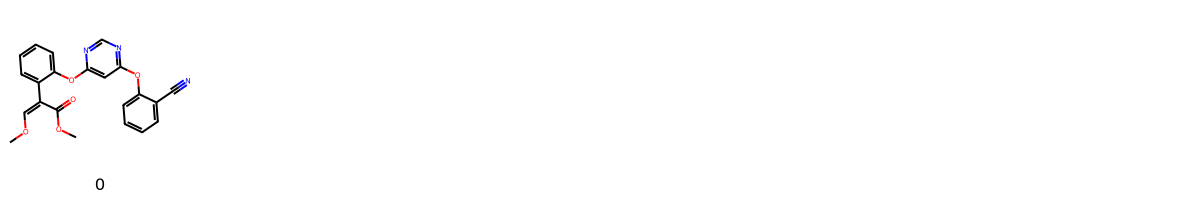

In [21]:
mu.show_mols([Chem.MolFromSmiles(n) for n in list(node_names.values()) if Chem.MolFromSmiles(n)])